In [23]:
import pandas as pd

pathLyrics = "./song-lyrics/lyrics-data.csv"
pathArtists = "./song-lyrics/artists-data.csv"

dataframeLyrics = pd.read_csv(pathLyrics)
dataframeArtists = pd.read_csv(pathArtists)

#Only English + lowercase
dataLyricsFilterd = dataframeLyrics[dataframeLyrics['Idiom'] == 'ENGLISH']
#dataLyricsFilterd = dataLyricsFilterd[dataLyricsFilterd['Lyric'] != 'Instrumental']
#dataLyricsFilterd = dataLyricsFilterd[dataLyricsFilterd['Lyric'] != 'Instrumental.']

dataLyricsFilterd = dataLyricsFilterd.apply(lambda x: x.astype(str).str.lower())
dataArtistsFilterd = dataframeArtists.apply(lambda x: x.astype(str).str.lower())


del dataArtistsFilterd['Genres']
del dataArtistsFilterd['Popularity']
del dataArtistsFilterd['Songs']


#print(first)

#print(dataLyricsFilterd)

dataArtistsFilterd = dataArtistsFilterd[dataArtistsFilterd['Genre'] != 'samba']
dataArtistsFilterd = dataArtistsFilterd[dataArtistsFilterd['Genre'] != 'sertanejo']
dataArtistsFilterd = dataArtistsFilterd[dataArtistsFilterd['Genre'] != 'funk carioca']

#Doppelte Artists ignorieren - erster Artist wird genommen
sorted = dataArtistsFilterd.sort_values(['Link'])

dataArtistsFilterd = sorted.groupby('Link').first().reset_index()

i = dataArtistsFilterd

#Kleinere Datenmenge!!
test = i[i['Artist'] == '10000 maniacs' ]
#print(test)
test2 = i[i['Artist'] == 'will.i.am' ]
test3 = i[i['Artist'] == 'jennifer lopez' ]
#test2


test = test.append(test2)
test = test.append(test3)
#Hier ungewünschte Begriffe einfügen
patternDel = ["---", "instrumental","==="]
for patt in patternDel:
    filter = dataLyricsFilterd['Lyric'].str.contains(patt)
    dataLyricsFilterd = dataLyricsFilterd[~filter]

      
    
    
#dataArtistsFilterd = test
#dataLyricsFilterd.to_csv('filterdData.csv')
#test
#dataArtistsFilterd

In [28]:
print(dataArtistsFilterd)
mergedData = pd.merge(dataLyricsFilterd, dataArtistsFilterd, how='inner', left_on='ALink',right_on='Link')

#print(mergedData)
del mergedData['ALink']
del mergedData['SName']
del mergedData['SLink']
del mergedData['Idiom']
del mergedData['Artist']
del mergedData['Link']
#mergedData
#mergedData.to_csv('mergedData.csv')

Link               Artist    Genre
0              /021-funcao/           021 função  hip hop
1           /10000-maniacs/        10000 maniacs     rock
2               /12-stones/            12 stones     rock
3                  /14-bis/               14 bis      pop
4                    /18-k/                 18 k  hip hop
...                     ...                  ...      ...
1980              /zona-22/              zona 22     rock
1981               /zootak/               zootak  hip hop
1982     /zulluu-predileto/     zulluu predileto  hip hop
1983  /zumzera-e-guilherme/  zumzera e guilherme     rock
1984               /zz-top/               zz top     rock

[1985 rows x 3 columns]


Lyric    Genre
69435  yeah! uh, it's on now, haha. yeah, haha, ja ru...  hip hop
46722  what am i supposed to do now?. reveal to me th...     rock
46037  talk to me. you never. talk to me. do we suffe...     rock
5468   you're talking, it all sounds fair. you promis...     rock
71190  i don't feel that she's mine enough. god, i fe...  hip hop
...                                                  ...      ...
7880   fuck you!. you, took what you wanted and left,...     rock
24001  ain’t that kindness. it had rained for 3 days ...     rock
19743  to binge. gorillaz. waiting by the mailbox, by...  hip hop
98180  heck yeah breathe you. darling i see you. i ho...      pop
48289  you don't have to move, you don't have to spea...     rock

[5000 rows x 2 columns]


<AxesSubplot:>

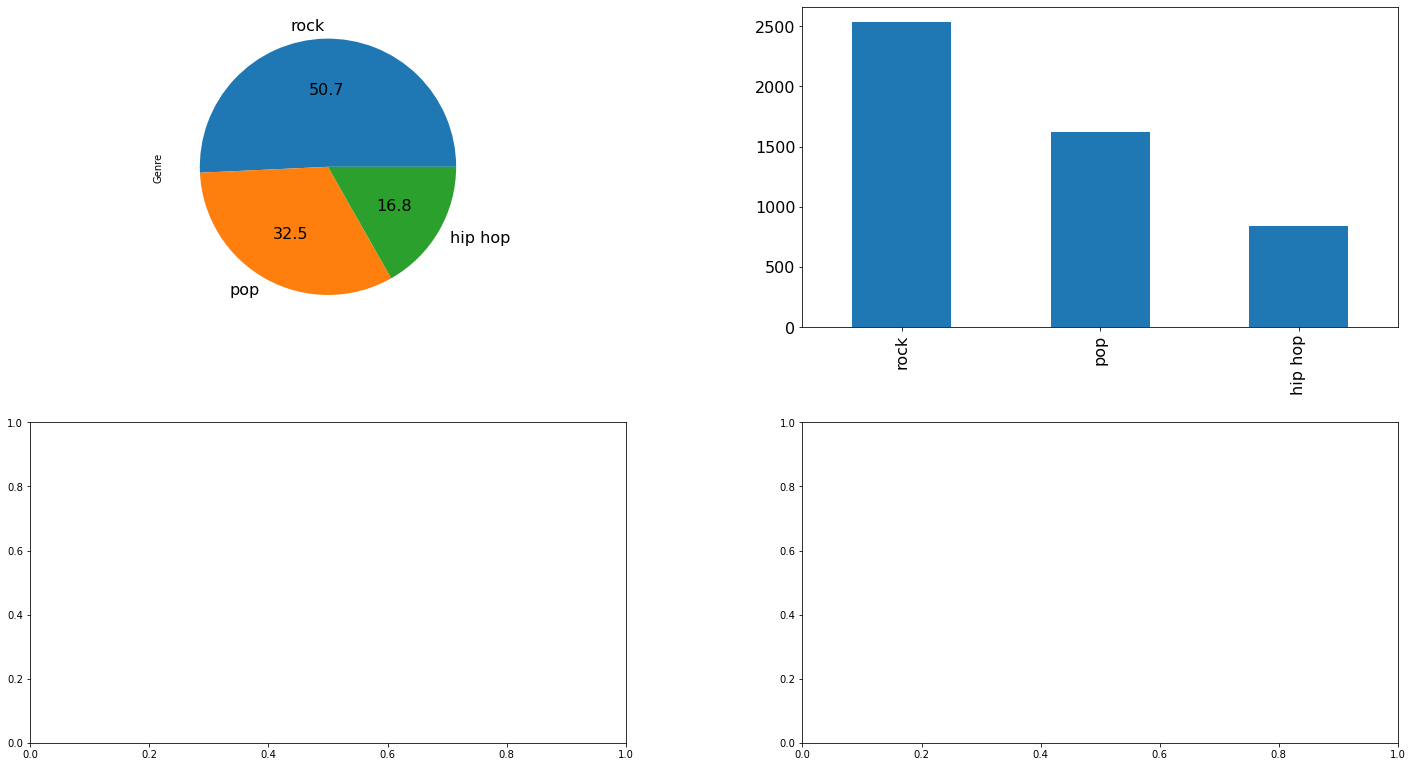

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
#import random as random

#random.shuffle(mergedData)

mergedData = mergedData.sample(5000)
print (mergedData)
genreCount = mergedData['Genre'].value_counts()

fig, axarr = plt.subplots(2, 2)
fig.tight_layout()


genreCount.plot.pie( figsize=(12, 12), fontsize=16, ax=axarr[0][0] , autopct='%.1f' )
genreCount.plot.bar( figsize=(22, 12), fontsize=16, ax=axarr[0][1] )



In [39]:
from collections import Counter 

replacement = {',','.','(',')','[chorus:]','-','/','?','!','[','&',']','"'}
print (replacement)
mergedData = mergedData.to_numpy()
for i in len(mergedData["Lyric"]):
#for index, lyric in enumerate(mergedData["Lyric"]):
    print(i)
    for repl in replacement:
        mergedData["Lyric"][i] = mergedData["Lyric"][i].replace(repl, ' ')
        
word_index = Counter(" ".join(mergedData["Lyric"]).split()).most_common(1000)




#for repl in replacement:
 #   string_temp = string_temp.replace(repl, ' ')
    #mergedData["Lyric"] = mergedData["Lyric"].replace(repl, ' ')

#word_index = Counter(" ".join(mergedData["Lyric"]).split()).most_common(1000)
#word_index = Counter(string_temp.split()).most_common(10000)
print(word_index)
#print(mergedData["Lyric"])

{'[chorus:]', '?', '!', '/', '[', ')', '"', '-', ']', '.', ',', '&', '('}


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [31]:
#most_common = set([t[0] for t in word_index]) 
most_common = []
for t in word_index:
    most_common.append(t[0])
    
#print(len(most_common))    
#print(most_common)
max_word_count = 0
xdata = []
xdata_boolean = []
ydata = []
ydata_integer = []
xdata_count = []
for lyric in mergedData['Lyric']:
    lyric_words_count = []
    cleared_lyrics_boolean = []
    max_word_count = 0
    for words in most_common:
        #print(words)
        count = lyric.count(' ' + words + ' ')
        lyric_words_count.append(count)
        if count != 0:
            cleared_lyrics_boolean.append(1)
        else:
            cleared_lyrics_boolean.append(lyric_words_count[-1])

        if count > max_word_count:
            max_word_count = count
            #print(lyric)
            #print(words)
    for idx, val in enumerate(lyric_words_count):
        lyric_words_count[idx] = val/max_word_count

    xdata_count.append(lyric_words_count)
    xdata_boolean.append(cleared_lyrics_boolean)
print(xdata_count[4])    
    
    #lyric_words = lyric.split()
    #cleared_lyrics = ''
    #cleared_lyrics_boolean = []
    #for word in lyric_words:
    #    if word in most_common:
    #        cleared_lyrics += word + ' '
    #for words in most_common:
    #    if words in lyric:
    #        cleared_lyrics_boolean.append(1)
    #    else:
            #print("Nicht Vorhanden "+words)
    #        cleared_lyrics_boolean.append(0)
    #xdata.append(cleared_lyrics)
    #xdata_boolean.append(cleared_lyrics_boolean)
#print(xdata_boolean[0])      
    #print("Lyric Normal:")
    #print(lyric)
    #print("Lyric Cleared:")
    #print(cleared_lyrics)

    
    
for genre in mergedData['Genre']:
    if genre == "rock": 
        ydata_integer.append([1,0,0]);
        ydata.append(0);
    
    elif genre == "pop": 
        ydata_integer.append([0,1,0]);
        ydata.append(1);
     
    elif genre == "hip hop": 
        ydata_integer.append([0,0,1]);
        ydata.append(2);
        
#print (ydata_integer[0])
print(max_word_count)

#xdata_count_nomalized = []
#for val in xdata_count:
#    iarray = []
#    for ival in val:
#        iarray.append(ival/max_word_count)
#    xdata_count_nomalized.append(iarray)

#print(xdata_count_nomalized)

NameError: name 'word_index' is not defined

In [32]:
import numpy as np
from keras import models
from keras import layers
import keras as keras

from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(xdata_count,ydata_integer, test_size=0.2)

def vectorize_sequences(sequences, dimensions=1000):
    results = np.zeros((len(sequences), dimensions))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

#print(test_data)

#X_train = vectorize_sequences(train_data)
#X_test = vectorize_sequences(test_data)
X_train = np.asarray(train_data).astype('float32')
X_test = np.asarray(test_data).astype('float32')

#print(test_labels)

print(X_train)
#print(train_data)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

#print(X_train)

model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(1000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='sigmoid'))
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
#keras.utils.plot_model(model, show_shapes=True)

history = model.fit(X_train, y_train, epochs=1000, batch_size=100, validation_split=0.2)

# compute loss and accuracy on test data
score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

NameError: name 'xdata_count' is not defined

In [33]:
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

history_dict = history.history
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation accuracy')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

NameError: name 'history' is not defined

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

train_data, test_data, train_labels, test_labels = train_test_split(xdata_count,ydata, test_size=0.2)


X_train = np.asarray(train_data).astype('float32')
X_test = np.asarray(test_data).astype('float32')

#print(test_labels)

#print(X_train)
#print(train_data)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')






## Naive Bayes mit additiver Glättung trainieren
nb = MultinomialNB(alpha=1.0)
nb.fit(X_train, y_train)

## Vorhersagen berechnen
y_predicted = nb.predict(X_test)

## Konfusionsmatrix ausgeben
print("Kofusionsmatrix:\n", confusion_matrix(y_true=y_test, y_pred=y_predicted))

## Gütemaße ausgeben
print("Korrektklassifizierungsrate:\n", accuracy_score(y_true=y_test, y_pred=y_predicted))
print("Präzision (mikro):\n", precision_score(y_true=y_test, y_pred=y_predicted, average='micro'))
print("Ausbeute (mikro):\n", recall_score(y_true=y_test, y_pred=y_predicted, average='micro'))
print("F1 (mikro):\n", f1_score(y_true=y_test, y_pred=y_predicted, average='micro'))

NameError: name 'xdata_count' is not defined

In [35]:
from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Embedding
from keras.layers import Flatten
from keras.preprocessing import sequence
# number of most frequent words to consider
num_words = 1000
# maximum length of lyrics (only the first so many words are considered)
max_len = 5920
# embedding dimensionality
emb_dim = 32
# describe model architecture
model = Sequential()
model.add(Embedding(num_words, emb_dim, input_length=max_len))
model.add(SimpleRNN(32, recurrent_dropout=0.2, dropout=0.2))
model.add(Dense(3, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)
# compute loss and accuracy on test data
score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

NameError: name 'X_train' is not defined